In [3]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import pyreadr

from utils import helpers

from importlib import reload

In [4]:
# Load Outfield Data

# Dan Data

outfield_dims = pyreadr.read_r('fences.rds')[None]

outfield_dims['spray_angle'] = outfield_dims.apply(lambda x: helpers.spray_angle(x.x, x.y),1) 

outfield_dims['team_abv'] = outfield_dims['team'].apply(lambda x: helpers.mapping[x])

# Ben Data

new_dims = pd.read_csv('data/mlb_stadia_paths.csv')

team_maps = pd.read_csv('data/team_maps2.csv')

In [5]:
# Load Judge Data, dropping an unneeded column and filtering to just the regular season, also dropping instances where the spray angle isn't available

aj = pd.read_csv('data/Judge2022.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06" and description != "foul"')
aj['true_homerun'] = aj['num_homers'].apply(lambda x: 1 if x == 30 else 0)

def spray_fix(x):
    if x < -45:
        return -44.9
    elif x > 45:
        return 44.9
    else:
        return x
    
aj['spray_angle_true'] = aj['spray_angle_true'].apply(lambda x: spray_fix(x),1)

C:\Users\noahs\AppData\Local\Temp\ipykernel_28992\1788960890.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aj = pd.read_csv('data/Judge2022.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06" and description != "foul"')


In [6]:
# The full dataset

df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06"').query('description != "foul"').reset_index(drop=True)

df_full['true_homerun'] = df_full['num_homers'].apply(lambda x: 1 if x == 30 else 0)

df_full['spray_angle_true'] = df_full['spray_angle_true'].apply(lambda x: spray_fix(x),1)

ids = pd.read_csv('data/players_id.csv')

df_full = df_full.merge(ids[['MLBID','PLAYERNAME']],how='left',left_on='batter',right_on='MLBID')

df_full = df_full.query('PLAYERNAME.notnull()')

df_full.drop_duplicates(inplace=True)

C:\Users\noahs\AppData\Local\Temp\ipykernel_28992\2341426491.py:3: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06"').query('description != "foul"').reset_index(drop=True)
C:\Users\noahs\AppData\Local\Temp\ipykernel_28992\2341426491.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06"').query('description != "foul"').reset_index(drop=True)


In [60]:
# This generates a dataframe that has the number of home runs aaron judge wouldve hit if he played every game as that stadium

hr_count = []
for t in df_full['home_team'].unique():
    hr_count.append(aj[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],t,x[6]),1).sum())

hr_count_by_stadium = pd.DataFrame(zip(df_full['home_team'].unique(), hr_count), columns=['Stadium','HR Count']).sort_values('HR Count',ascending=False).reset_index(drop=True)

hr_count_by_stadium

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: inv

,Stadium,HR Count
0,CIN,71
1,CWS,67
2,PHI,66
3,MIL,66
4,TOR,66
5,NYY,65
6,LAD,64
7,COL,63
8,DET,63
9,CHC,63


In [7]:
def field_comp(x):
    if x[0] == "home_run" and x[1] == 1:
        return "hr"
    elif x[0] == "home_run" and x[1] == 0:
        return "no_hr"
    elif x[0] != "home_run" and x[1] == 0:
        return "never_hr"
    elif x[0] != "home_run" and x[1] == 1:
        return "new_hr"

In [22]:
aj.sort_values("spray_angle_true")[['hit_distance_sc','spray_angle_true','hc_x_','hc_y_','true_homerun']]

,hit_distance_sc,spray_angle_true,hc_x_,hc_y_,true_homerun
16,304,-44.261250,-196.783658,201.924741,0
129,300,-44.036884,-210.909156,218.121645,0
32,450,-44.000000,NaN,NaN,0
76,410,-42.920307,-283.133875,304.471862,1
29,404,-41.973454,-273.825022,304.396992,1
...,...,...,...,...,...
131,327,35.178153,190.719178,270.580650,0
143,355,36.765112,215.625974,288.599394,0
135,294,37.291049,180.611710,237.163615,0
168,364,37.729440,226.207619,292.367858,0


In [16]:
aj.query("spray_angle_true.isna()")

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,spray_angle_true,launch_speed_fts,launch_angle_rads,num_homers,MLBID,PLAYERNAME,batter_name,true_homerun,temp_hr,field_comp
32,SI,2022-09-04,94.4,-2.22,5.82,"Armstrong, Shawn",592450,542888,home_run,hit_into_play,...,NaN,169.106667,0.523599,0,592450.0,Aaron Judge,"Judge, Aaron",0,0,no_hr


In [23]:
aj.loc[32, "spray_angle_true"] = -44
aj.loc[32, "hc_x_"] = -305
aj.loc[32, "hc_y_"] = 310
aj.loc[32, "field_comp"] = 'hr'
aj.loc[32, "true_homerun"] = 1
aj.loc[32, "temp_hr"] = 1


In [80]:
aj.query('field_comp == "new_hr"')[['hit_distance_sc','hc_x_','hc_y_','spray_angle_true','temp_hr','field_comp']]

,hit_distance_sc,hc_x_,hc_y_,spray_angle_true,temp_hr,field_comp
68,340,179.688312,294.264568,31.409709,1,new_hr
141,397,-148.667121,314.155065,-25.324845,1,new_hr
173,354,186.351754,306.069091,31.335362,1,new_hr


In [61]:
aj.to_csv('data/CIN.csv')

In [81]:
np.random.random()

0.9795074236384829

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


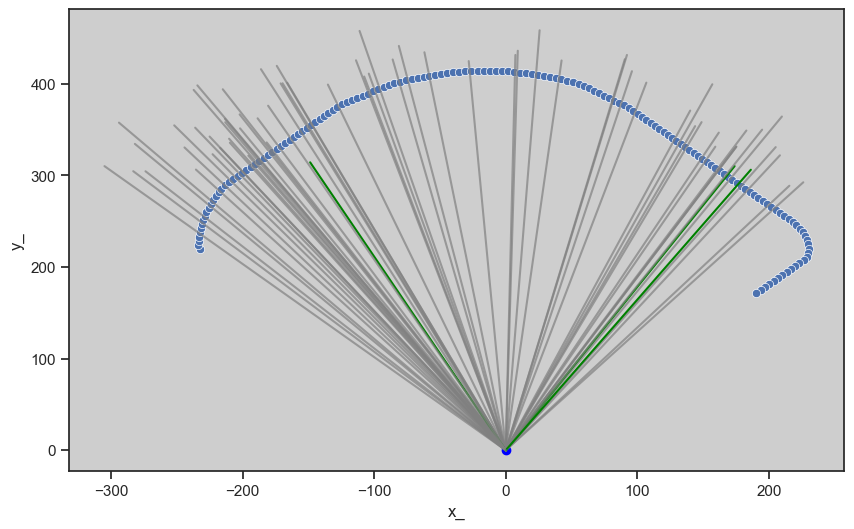

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing code for data manipulation
aj['temp_hr'] = aj[['launch_speed_fts', 'launch_angle_rads', 'plate_z', 'hit_distance_sc', 'spray_angle_true', 'home_team', 'events']].apply(lambda x: helpers.is_home_run_new_team(x[0], x[1], x[2], x[3], x[4], x[5], 'NYY', x[6]), 1)
aj['field_comp'] = aj[['events', 'temp_hr']].apply(lambda x: field_comp(x), 1)

aj.loc[68, "hc_x_"] = 174
aj.loc[68, "hc_y_"] = 310
aj.loc[32, "spray_angle_true"] = -44
aj.loc[32, "hc_x_"] = -305
aj.loc[32, "hc_y_"] = 310
aj.loc[32, "field_comp"] = 'hr'
aj.loc[32, "true_homerun"] = 1
aj.loc[32, "temp_hr"] = 1

# Create figure and axes
plt.figure(figsize=(10, 6))
ax = plt.axes()

# Set background color
ax.set_facecolor('#cecece')

# Plotting the scatterplot
sns.scatterplot(data=team_maps.query('team == "NYY"'), x='x_', y='y_', ax=ax)

# Plot home plate
plt.plot(0, 0, marker='o', color='blue')

# Plot lines
for x, y, hr in zip(aj['hc_x_'], aj['hc_y_'], aj['field_comp']):
    if hr == "hr":
        plt.plot([0, x], [0, y], 'grey',alpha=.7)
    elif hr == "no_hr": 
        plt.plot([0, x], [0, y], 'red')
    elif hr == "new_hr": 
        plt.plot([0, x], [0, y], 'green')

# Remove gridlines
ax.grid(False)

plt.show()


In [55]:
aj['temp_hr'] = aj[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],'BAL',x[6]),1)

aj['field_comp'] = aj[['events','temp_hr']].apply(lambda x: field_comp(x),1)

aj.loc[32, "spray_angle_true"] = -44
aj.loc[32, "hc_x_"] = -305
aj.loc[32, "hc_y_"] = 310
aj.loc[32, "field_comp"] = 'hr'
aj.loc[32, "true_homerun"] = 1
aj.loc[32, "temp_hr"] = 1

plt.figure(figsize=(12,8),facecolor='lightgrey')
sns.set_style("ticks", {'axes.grid': False},{'axes.facecolor':'#cecece'})
# sns.set(rc={'axes.facecolor':'#cecece', 'figure.facecolor':'lightgrey'})
sns.scatterplot(data=team_maps.query('team == "BAL"'),x='x_',y='y_',size=4)
# plt.plot(0,0,marker='o')

# for dist, angle, hr in zip(aj['hit_distance_sc'], aj['spray_angle_true'],aj['field_comp']):
#     x = dist * np.cos(np.deg2rad(angle * -1)) 
#     y = dist * np.sin(np.deg2rad(angle * -1))
    
#     x_rotated = -y
#     y_rotated = x

#     if hr == "hr":
#         plt.plot([0,x_rotated],[0,y_rotated],'grey',alpha=.8)
#     elif hr == "no_hr": 
#         plt.plot([0,x_rotated],[0,y_rotated],'red')
#     elif hr == "new_hr": 
#         plt.plot([0,x_rotated],[0,y_rotated],'green')


c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


TypeError: set_style() takes from 0 to 2 positional arguments but 3 were given

<Figure size 1200x800 with 0 Axes>

In [64]:
aj

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,spray_angle_true,launch_speed_fts,launch_angle_rads,num_homers,MLBID,PLAYERNAME,batter_name,true_homerun,temp_hr,field_comp
9,FF,2022-10-04,97.3,-1.90,5.64,"Gray, Jon",592450,592351,field_out,hit_into_play,...,20.029151,139.773333,0.750492,0,592450.0,Aaron Judge,"Judge, Aaron",0,0,never_hr
10,SL,2022-10-04,88.4,-1.71,5.69,"Tinoco, Jesus",592450,622786,home_run,hit_into_play,...,-33.342618,146.960000,0.610865,30,592450.0,Aaron Judge,"Judge, Aaron",1,1,hr
11,SI,2022-09-28,94.5,1.78,6.46,"Mayza, Tim",592450,641835,home_run,hit_into_play,...,-28.412607,172.186667,0.383972,30,592450.0,Aaron Judge,"Judge, Aaron",1,1,hr
12,SL,2022-09-25,85.9,-1.79,5.62,"Bello, Brayan",592450,678394,field_out,hit_into_play,...,-14.718110,144.906667,0.767945,0,592450.0,Aaron Judge,"Judge, Aaron",0,0,never_hr
13,FF,2022-09-24,95.1,-1.28,6.64,"Pivetta, Nick",592450,601713,field_out,hit_into_play,...,2.747242,158.546667,0.750492,0,592450.0,Aaron Judge,"Judge, Aaron",0,0,never_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,FF,2022-04-14,96.0,-2.54,5.87,"Gausman, Kevin",592450,592332,field_out,hit_into_play,...,-3.189726,144.320000,0.488692,0,592450.0,Aaron Judge,"Judge, Aaron",0,0,never_hr
176,FF,2022-04-14,94.2,-2.46,5.91,"Gausman, Kevin",592450,592332,field_out,hit_into_play,...,10.502114,134.200000,0.471239,0,592450.0,Aaron Judge,"Judge, Aaron",0,0,never_hr
177,SI,2022-04-13,91.9,-3.18,5.21,"Berríos, José",592450,621244,home_run,hit_into_play,...,-25.661900,158.986667,0.471239,30,592450.0,Aaron Judge,"Judge, Aaron",1,1,hr
178,FC,2022-04-12,91.1,1.12,5.50,"Kikuchi, Yusei",592450,579328,field_out,hit_into_play,...,-32.538199,140.360000,0.506145,11,592450.0,Aaron Judge,"Judge, Aaron",0,1,new_hr


In [61]:
# Scheduling data and function

reload(helpers)

sched = pd.read_csv('data/mlb_sched.csv')

sched['Stadium'] = sched['Field'].apply(lambda x: helpers.sched_maps[x])
sched['Tm'] = sched['Tm'].apply(lambda x: helpers.sched_maps[x])

def judge_sched(team, mlb_sched, judge_game_map):
    team_sched = mlb_sched[mlb_sched['Tm']==team]
    judge_game_map = judge_game_map.merge(team_sched[['Game_Num','Stadium']],left_on='Game_Num',right_on='Game_Num')
    return judge_game_map

In [65]:
aj = aj.merge(pd.read_csv('data/judge_hit_map.csv')[['game_date','hc_x','hc_y','launch_angle','Game_Num']], left_on=['game_date','hc_x','hc_y','launch_angle'], right_on=['game_date','hc_x','hc_y','launch_angle'], how='left')

In [110]:
judge_sched('SD',sched, aj)[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','Stadium','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]),1).sum()


launch_speed_fts     0.0
launch_angle_rads    0.0
plate_z              0.0
hit_distance_sc      0.0
spray_angle_true     0.0
home_team            0.0
Stadium              0.0
events               0.0
dtype: float64

In [66]:
team_count = []

for team in df_full['home_team'].unique():
    val = judge_sched(team,sched, aj)[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','Stadium','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]),1).sum()
    team_count.append(val)

hr_count_by_team_sched = pd.DataFrame(zip(df_full['home_team'].unique(), team_count), columns=['Team','HR Count']).sort_values('HR Count',ascending=False).reset_index(drop=True)

hr_count_by_team_sched

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:305: RuntimeWarning: inv

,Team,HR Count
0,CIN,67
1,LAD,65
2,CWS,65
3,CLE,64
4,COL,63
5,MIN,63
6,KC,63
7,DET,63
8,MIL,62
9,NYY,62


In [67]:
hr_count_by_stadium.columns = ['Team','HR_Count']
hr_count_by_stadium.to_csv("data/hr_stad.csv")

In [69]:
hr_count_by_team_sched.columns = ['Team','HR_Count']
hr_count_by_team_sched.to_csv("data/hr_sched.csv")

In [70]:
# True Homerun counts

reload(helpers)

aj['num_homers'] = aj[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.num_homers(x[0],x[1],x[2],x[3],x[4],x[5],x[6]),1)

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:264: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


In [72]:
vals

,index,num_homers
0,30,38
1,29,11
2,25,2
3,21,2
4,19,2
5,24,1
6,22,1
7,5,1
8,27,1
9,4,1


In [73]:
vals = pd.DataFrame(aj.query('events == "home_run"')['num_homers'].value_counts().reset_index())

# print(f"Number of HRs that were only a HR at Yankee Stadium: {vals.query('index == 1')['num_homers'].item()}")
print(f"Number of HRs that were a HR at half the stadiums: {vals.query('index >= 15')['num_homers'].sum()}")
print(f"Number of HRs that were only a HR at every stadium: {vals.query('index == 30')['num_homers'].item()}")


Number of HRs that were a HR at half the stadiums: 60
Number of HRs that were only a HR at every stadium: 38


In [74]:
vals = pd.DataFrame(aj.query('events != "home_run"')['num_homers'].value_counts().reset_index())

print(f"Number of non-HR hits that would have been a homer somewhere: {vals.query('index >= 1')['num_homers'].sum()}")
print(f"Number of non-HR hits that would have been a HR at half the stadiums: {vals.query('index >= 15')['num_homers'].sum()}")

Number of non-HR hits that would have been a homer somewhere: 16
Number of non-HR hits that would have been a HR at half the stadiums: 3


In [81]:
df_full['hr'] = df_full['events'].apply(lambda x: 1 if x == 'home_run' else 0)

In [120]:
top500

,PLAYERNAME,game_year,home_runs,True_HR,Perc
0,Aaron Judge,2022,62,38,0.613
1,Giancarlo Stanton,2017,59,24,0.407
2,Pete Alonso,2019,53,19,0.358
3,Matt Olson,2023,53,23,0.434
4,Aaron Judge,2017,50,22,0.440
...,...,...,...,...,...
495,Trevor Story,2017,24,5,0.208
496,Willy Adames,2023,24,5,0.208
497,Anthony Rendon,2017,24,12,0.500
498,Roberto Perez,2019,24,8,0.333


In [83]:
top15 = df_full.groupby('PLAYERNAME').agg(home_runs=('hr', 'sum')).reset_index().sort_values('home_runs',ascending=False).head(15)

In [77]:
# The full dataset

df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('description != "foul"').reset_index(drop=True)

df_full['true_homerun'] = df_full['num_homers'].apply(lambda x: 1 if x == 30 else 0)

df_full['spray_angle_true'] = df_full['spray_angle_true'].apply(lambda x: spray_fix(x),1)

ids = pd.read_csv('data/players_id.csv')

df_full = df_full.merge(ids[['MLBID','PLAYERNAME']],how='left',left_on='batter',right_on='MLBID')

df_full = df_full.query('PLAYERNAME.notnull()')

df_full.drop_duplicates(inplace=True)

C:\Users\noahs\AppData\Local\Temp\ipykernel_17284\1459559201.py:3: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('description != "foul"').reset_index(drop=True)
C:\Users\noahs\AppData\Local\Temp\ipykernel_17284\1459559201.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('description != "foul"').reset_index(drop=True)


In [84]:
df_full.query('game_type == "R"',inplace=True)

In [97]:
df_full.query("spray_angle_true.isna() and PLAYERNAME == 'Aaron Judge'")

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,hc_x_,hc_y_,spray_angle_true,launch_speed_fts,launch_angle_rads,num_homers,true_homerun,MLBID,PLAYERNAME,hr
78562,SL,2017-06-11,84.7,-1.98,5.69,"Verrett, Logan",592450,548337,home_run,hit_into_play,...,NaN,NaN,NaN,173.946667,0.488692,0,0,592450.0,Aaron Judge,1
83274,CH,2017-05-14,82.3,-1.35,6.07,"Fiers, Mike",592450,571666,home_run,hit_into_play,...,NaN,NaN,NaN,160.893333,0.471239,0,0,592450.0,Aaron Judge,1
84965,SI,2017-05-03,93.4,-1.53,5.41,"Stroman, Marcus",592450,573186,home_run,hit_into_play,...,NaN,NaN,NaN,165.000000,0.541052,0,0,592450.0,Aaron Judge,1
91417,FC,2018-09-24,88.6,3.07,5.06,"Yarbrough, Ryan",592450,642232,double,hit_into_play,...,NaN,NaN,NaN,136.546667,0.349066,0,0,592450.0,Aaron Judge,0
103772,SI,2018-07-09,96.0,-2.57,5.49,"Yacabonis, Jimmy",592450,642231,field_out,hit_into_play,...,NaN,NaN,NaN,138.453333,0.383972,0,0,592450.0,Aaron Judge,0
111593,FF,2018-05-23,92.0,-1.56,5.56,"Barnette, Tony",592450,501817,home_run,hit_into_play,...,NaN,NaN,NaN,164.266667,0.488692,0,0,592450.0,Aaron Judge,1
116876,SI,2018-04-21,92.6,-1.19,5.46,"Stroman, Marcus",592450,573186,home_run,hit_into_play,...,NaN,NaN,NaN,170.280000,0.523599,0,0,592450.0,Aaron Judge,1
117060,CH,2018-04-20,76.9,-0.94,6.58,"Estrada, Marco",592450,462136,field_out,hit_into_play,...,NaN,NaN,NaN,140.360000,0.610865,0,0,592450.0,Aaron Judge,0
118227,SL,2018-04-12,84.7,-1.81,6.03,"Porcello, Rick",592450,519144,double,hit_into_play,...,NaN,NaN,NaN,169.693333,0.296706,0,0,592450.0,Aaron Judge,0
201596,SI,2022-09-04,94.4,-2.22,5.82,"Armstrong, Shawn",592450,542888,home_run,hit_into_play,...,NaN,NaN,NaN,169.106667,0.523599,0,0,592450.0,Aaron Judge,1


In [85]:
top500 = df_full.groupby(['PLAYERNAME','game_year']).agg(home_runs=('hr', 'sum')).reset_index().sort_values('home_runs',ascending=False).head(500)

In [86]:
top500dict = {}

for player, year in zip(top500['PLAYERNAME'],top500['game_year']):
    temp = df_full.query(f'PLAYERNAME == "{player}" and game_year == {year}')
    temp['num_hr'] = temp[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.num_homers(x[0],x[1],x[2],x[3],x[4],x[5],x[6]),1)
    key = player + ',' + str(year)
    top500dict[key] = len(temp.query('events == "home_run" and num_hr == 30'))

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:264: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
C:\Users\noahs\AppData\Local\Temp\ipykernel_17284\4229480362.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['num_hr'] = temp[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.num_homers(x[0],x[1],x[2],x[3],x[4],x[5],x[6]),1)
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:264: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distanc

In [89]:
truehrs = pd.DataFrame.from_dict(top500dict, orient='index').reset_index().rename(columns={'index':'PLAYERNAME',0:'True_HR'})

In [118]:
top500.query("game_year == 2022").sort_values(["home_runs","True_HR"],ascending=[False,False]).head(15).to_csv("data/top15.csv")

In [94]:
top500 = top500.merge(truehrs,on=['PLAYERNAME','game_year'],how='left').assign(Perc = lambda x: round(x['True_HR'] / x['home_runs'],3))

In [92]:
truehrs['game_year'] = truehrs['PLAYERNAME'].apply(lambda x: x.split(',')[1])
truehrs['PLAYERNAME'] = truehrs['PLAYERNAME'].apply(lambda x: x.split(',')[0])

In [93]:
truehrs['game_year'] = truehrs['game_year'].astype(int)

In [110]:
top500

,PLAYERNAME,game_year,home_runs,True_HR,Perc
0,Aaron Judge,2022,62,38,0.613
1,Giancarlo Stanton,2017,59,24,0.407
2,Pete Alonso,2019,53,19,0.358
3,Matt Olson,2023,53,23,0.434
4,Aaron Judge,2017,50,22,0.440
...,...,...,...,...,...
495,Trevor Story,2017,24,5,0.208
496,Willy Adames,2023,24,5,0.208
497,Anthony Rendon,2017,24,12,0.500
498,Roberto Perez,2019,24,8,0.333


In [111]:
top500.to_csv('data/top500.csv')

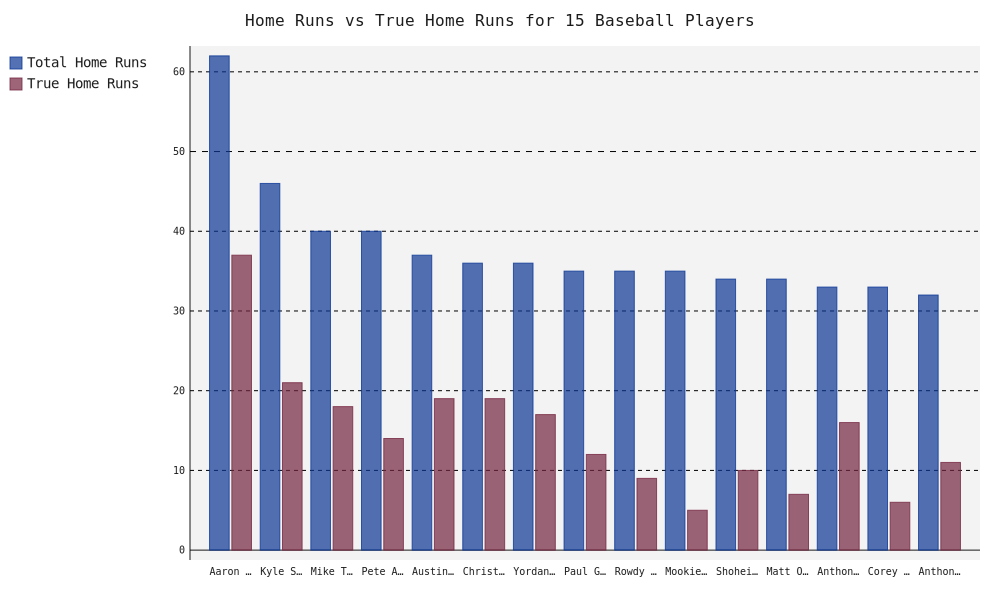

In [287]:
import pygal
from pygal.style import CleanStyle
from IPython.display import display, SVG

# Create a new bar chart with custom style
bar_chart = pygal.Bar(style=CleanStyle, width=1000, height=600)
bar_chart.title = 'Home Runs vs True Home Runs for 15 Baseball Players'

# Setting up the x labels (Player names)
bar_chart.x_labels = top15['PLAYERNAME']

# Adding data series-by-series
bar_chart.add('Total Home Runs', top15['home_runs'].tolist())
bar_chart.add('True Home Runs', top15['True_HR'].tolist())

# Display the SVG in Jupyter Notebook
display(SVG(bar_chart.render()))

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

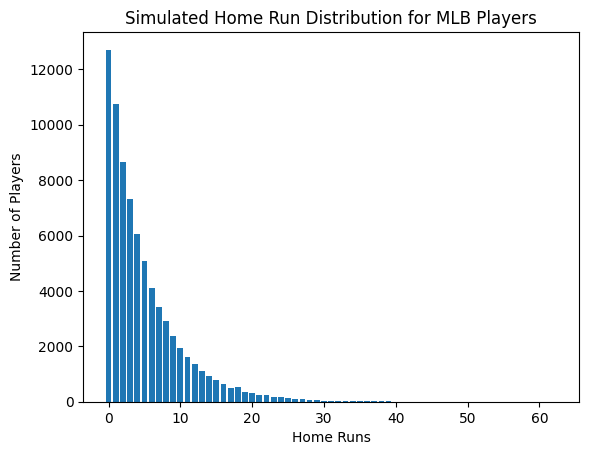

In [4]:
total_players = 75000

# Exponential distribution parameter (lambda)
# This can be adjusted to fit the distribution
# Higher lambda means more players with fewer home runs
lmbda = 0.3

# Generate values from an exponential distribution
exp_values = np.random.exponential(scale=1/lmbda, size=total_players)

# Discretize and scale the values to be between 0 and 62
hr_values = np.clip(np.floor(exp_values * (62 / exp_values.max())), 0, 62)

# Count the frequency of each home run value
hr_counts = np.bincount(hr_values.astype(int))

# Display the distribution
plt.bar(range(len(hr_counts)), hr_counts)
plt.xlabel('Home Runs')
plt.ylabel('Number of Players')
plt.title('Simulated Home Run Distribution for MLB Players')
plt.show()

In [5]:
hr_counts

array([12706, 10743,  8671,  7307,  6045,  5069,  4122,  3419,  2896,
        2383,  1949,  1612,  1355,  1123,   930,   771,   653,   508,
         521,   344,   329,   253,   225,   162,   158,   118,    84,
         108,    79,    61,    41,    38,    37,    32,    16,    17,
          19,    19,    19,    12,     5,     8,     5,     5,     5,
           1,     7,     2,     1,     0,     1,     0,     2,     1,
           0,     0,     1,     0,     1,     0,     0,     0,     1],
      dtype=int64)